In [332]:
import parse_data.preprocess as preprocess
import parse_data.loading as loading
from analysis.response_times import calculate_response_times, plot_response_times
import globals
from plotting import plot_octagon, plot_trajectory
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

In [333]:
# paths
# data_folder = '/home/tom/Documents/SWC/data' # desktop Duan Lab
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-53-34_YansuSecondSolo.json' 
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-31-00_YansuJerrySocial.json'
data_folder = r'D:\Users\Tom\OneDrive\PhD\SWC\data' # desktop home
# json_filename = r'first_experiments_2409\240913\2024-09-13_11-23-37_YansuFirstSolo.json'
json_filename = r'first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json'


In [334]:
# Load JSON file into pandas df with collapsed data dictionary and adjustments based on date of recording 
df = loading.loading_pipeline(data_folder, json_filename)

Data is from period before 2024-09-13 11:31:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.


In [335]:
# Pre-process data 
df = preprocess.standard_preprocessing(df)

Preprocessing complete.


In [336]:
## Extract single trials ##

In [337]:
def split_session_by_trial(df):
    
    # groupby produces an interable of tuples with the group key and the dataframe 
    trials_list = [data for _, data in df.groupby('data.trialNum')]
    
    # exclude trial 0 (could also exclude trial 1)
    trials_list = trials_list[1:]

    # if final  trial does not contain a server selected trigger activation, discard it
    if not globals.SELECTED_TRIGGER_ACTIVATION in trials_list[-1]['eventDescription'].unique():
        trials_list = trials_list[:-1]

    return trials_list


In [338]:
trial_list = split_session_by_trial(df)

In [339]:
## rotate trials ##

In [340]:
def find_rotation_angle_trial(trial_list, trial_index):
    """ Find CCW angle of rotation for vector to 
    rotate arena s.t. high wall is at wall 1"""

    trial = trial_list[trial_idx]
    
    # identify trial walls
    wall1 = trial.iloc[0]['data.wall1']
    wall2 = trial.iloc[0]['data.wall2']
    
    # find difference of high wall to wall 1
    difference = wall1 - 1
        
    # find CCW rotation angle 
    unitary_rotation_ang = 2*math.pi/globals.NUM_WALLS
    theta = unitary_rotation_ang * difference

    return theta

In [341]:
# for i in range(len(trial_list)):
#     wall1 = trials_list[i].iloc[0]['wall1']
#     wall2 = trials_list[i].iloc[0]['wall2']
#     if wall1 > wall2:
#         for i in range(len(this_rotated_coordinates):
#             rotated_coordinates[i][0] = -rotated_coordinates[i][0]

In [342]:
def flip_trajectories(altered_coordinates):
    ''' If wall1 is CW of wall2, flip the x coordinate
        of the trajectory data around. This keeps wall1
        CCW of wall2 '''
    

    altered_coordinates[0] = -altered_coordinates[0]

    return altered_coordinates
    

In [343]:
def flip_rotate(trial_list, trial_index, theta, flip=True):
    """ Take counterclockwise rotation angle and starting vector
        Flip x coordinates of vector if wall2 CCW of wall1
        Return altered vector """

    altered_coordinates = []
    trial = trial_list[trial_idx]
    num_players = preprocess.num_players(df)
    
    trial_copy = trial.copy()

    # create rotation matrix
    rotM = np.array([
                    [math.cos(theta), -math.sin(theta)],
                     [math.sin(theta), math.cos(theta)]
                    ])

    for i in range(num_players):
        x,y = trial_copy[globals.PLAYER_LOC_DICT[i]['xloc']], trial_copy[globals.PLAYER_LOC_DICT[i]['yloc']]

        this_coordinates = np.vstack([x,y])
        this_altered_coordinates = np.matmul(rotM, this_coordinates) 

        # flip flag is a function parameter
        if flip:
            # flip coordinates around the x-axis if wall2 is CCW of wall1
            wall1 = trial.iloc[0]['data.wall1']
            wall2 = trial.iloc[0]['data.wall2']
            if wall1 > wall2:
                print(f"Trial index {trial_index} flipped. Wall 1 is {wall1}; wall2 is {wall2}")
                this_altered_coordinates = flip_trajectories(this_altered_coordinates)

        altered_coordinates.append(this_altered_coordinates)

    return altered_coordinates
    


In [344]:
def replace_with_altered_coordinates(trial_list, trial_index, altered_coordinates):
    trial = trial_list[trial_idx]
    trial_copy = trial.copy()

    # overwrite the x location and y location columns in a copy of the dataframe for this trial
    for i in range(len(altered_coordinates)):
        trial_copy[globals.PLAYER_LOC_DICT[i]['xloc']] = altered_coordinates[i][0] # x coordinates
        trial_copy[globals.PLAYER_LOC_DICT[i]['yloc']] = altered_coordinates[i][1] # y coordinates

    return trial_copy
        


In [345]:
trial_index = 1

In [346]:
trial = trial_list[trial_idx]

In [347]:
trial.iloc[0]

timeLocal                           1900-01-01 11:32:51.592000
timeApplication                         0 days 00:02:47.523000
eventDescription                                   trial start
data.playerPosition.0.clientId                             NaN
data.playerPosition.0.location.x                   5.654138088
data.playerPosition.0.location.y                   1.984999657
data.playerPosition.0.location.z                  15.102668762
data.playerPosition.0.rotation.x                   3.163929939
data.playerPosition.0.rotation.y                 150.668518066
data.playerPosition.0.rotation.z                  -0.000000107
data.playerPosition.1.clientId                             NaN
data.playerPosition.1.location.x                           NaN
data.playerPosition.1.location.y                           NaN
data.playerPosition.1.location.z                           NaN
data.playerPosition.1.rotation.x                           NaN
data.playerPosition.1.rotation.y                       

In [348]:
theta = find_rotation_angle_trial(trial_list, trial_index)

In [349]:
altered_coords = flip_rotate(trial_list, trial_index, theta)

Trial index 1 flipped. Wall 1 is 2.0; wall2 is 1.0
Trial index 1 flipped. Wall 1 is 2.0; wall2 is 1.0


In [350]:
    altered_coords = np.array(altered_coords)

In [351]:
altered_coords.shape

(2, 2, 489)

In [352]:
trial[globals.PLAYER_LOC_DICT[0]['xloc']]

5347     5.654138088
5348     5.654138088
5349     5.654138088
5350     5.654138088
5351     5.654138088
            ...     
5831    13.669239044
5832    13.669239044
5833    13.669239044
5834    13.669239044
5835    13.669239044
Name: data.playerPosition.0.location.x, Length: 489, dtype: float64

In [353]:
trial_copy = replace_with_altered_coordinates(trial_list, trial_index, altered_coords)

In [354]:
trial_copy[globals.PLAYER_LOC_DICT[0]['xloc']]

5347    6.681120112
5348    6.681120112
5349    6.681120112
5350    6.681120112
5351    6.681120112
           ...     
5831   -6.632216955
5832   -6.632216955
5833   -6.632216955
5834   -6.632216955
5835   -6.632216955
Name: data.playerPosition.0.location.x, Length: 489, dtype: float64

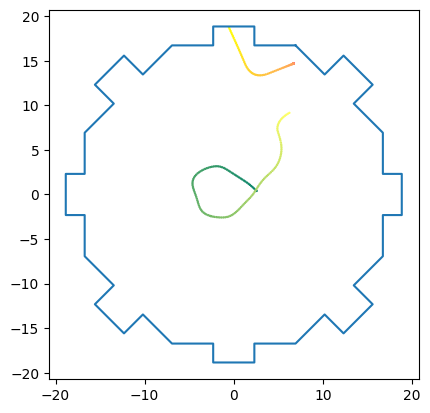

In [355]:
plot_trajectory.plot_trajectory(trials_list, trial_index=0, social=True, trial=trial_copy)

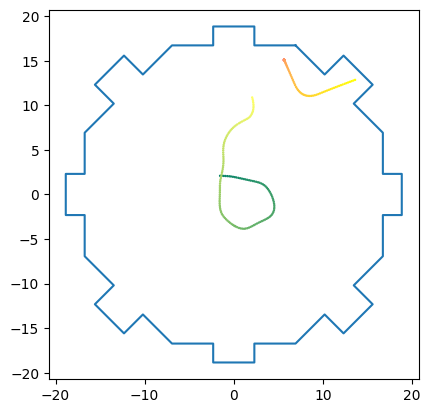

In [356]:
plot_trajectory.plot_trajectory(trials_list, trial_index=trial_idx, social=True)

In [357]:
trial_list[1]['data.wall2'].iloc[0]

np.float64(1.0)

In [358]:
flipped = []
for i in range(len(trials_list)):
    if trials_list[i]['data.wall1'].iloc[0] > trials_list[i]['data.wall2'].iloc[0]:
        flipped.append(i)

In [359]:
np.array(flipped)

array([  1,   2,   8,  10,  11,  13,  15,  17,  18,  19,  24,  25,  27,
        29,  33,  38,  39,  42,  44,  49,  51,  54,  56,  58,  61,  63,
        64,  65,  71,  73,  74,  76,  78,  81,  86,  91,  93,  94,  98,
        99, 101, 102, 107, 109, 110, 112, 114, 115, 118, 119, 120, 122,
       124, 128])